### Load meta data

In [3]:
include("/Users/simon/Documents/DTU fag/syntese/Code/syntese/coords2index/load_s1slc_ann.jl");

In [4]:
f = open("ann_path.txt")
path = readlines(f)
sar_parameters = load_s1slc_ann(path[1]);

test[1.0, 1343.0, 2684.0, 4027.0, 5368.0, 6710.0, 8053.0, 9393.0, 10735.0, 12078.0]


### Make read data function

In [3]:
using PyCall

In [4]:
function read_s1slc_data(path,view)
    rasterio = pyimport("rasterio")
    dataset = rasterio.open(path)
    
    # subtract one because array[a:b] in python retuns the (a+1)'th to b'th element
    window = ((view[1].start-1,view[1].stop),(view[2].start-1,view[2].stop))
    return dataset.read(1, window=window)
end

read_s1slc_data (generic function with 1 method)

### define view and read data

In [25]:
view = [2001:7000, 1001:9000]
f = open("data_path.txt")
path = readlines(f)
VVraw = read_s1slc_data(path[1],view);

 Img[2000,1000] not included
 
 Img[2001,1001] included  
 
 Img[7000,9000] included

## Make data structure

In [26]:
struct SlcRaw
    view::Array{UnitRange,1}
    meta::Dict
    data::Array{Complex,2}
end

In [27]:
test = SlcRaw(view, sar_parameters,VVraw);

### Make show function

In [28]:
using Statistics
using Images

In [29]:
function show_img(img,max_quantile=0.98) 
    return Gray.(abs.(img)./quantile(reshape(abs.(img), :), max_quantile))
end

function show_img(img::SlcRaw,max_quantile=0.98) 
    return show_img(img.data,max_quantile)
end

show_img (generic function with 4 methods)

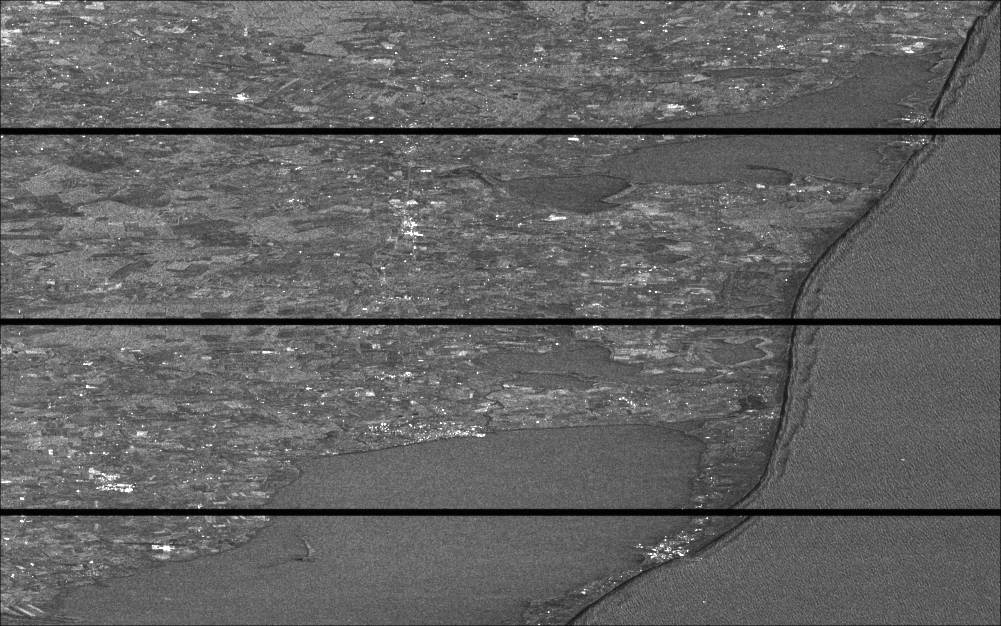

In [30]:
show_img(test)

## Get raw coordinates and footprint

In [31]:

scipy_interp = pyimport("scipy.interpolate");

In [32]:
function raw_coords(s1_ann,line,sample)
    line_goepoints = s1_ann["geolocation"]["line"]
    sample_goepoints = s1_ann["geolocation"]["sample"]
    latitude_goepoints = s1_ann["geolocation"]["latitude"]
    longitude_goepoints = s1_ann["geolocation"]["longitude"]
    
    
    point_latitude = scipy_interp.griddata(hcat(line_goepoints,sample_goepoints), 
                                            latitude_goepoints, (line,sample), method="linear")
    point_logitude = scipy_interp.griddata(hcat(line_goepoints,sample_goepoints),
                                            longitude_goepoints, (line,sample), method="linear")
    
    return point_latitude,point_logitude
end

raw_coords (generic function with 1 method)

In [33]:
function get_footprint(s1_ann,view)
    line = [view[1].start,view[1].stop,view[1].stop,view[1].start]
    sample = [view[2].start,view[2].start,view[2].stop,view[2].stop]    
        return raw_coords(s1_ann,line,sample)   
end


function get_footprint(img::SlcRaw)
    return get_footprint(img.meta,img.view)
end

get_footprint (generic function with 2 methods)

In [34]:
lat,lon = get_footprint(test)

([56.4575, 55.9173, 55.9582, 56.4984], [8.56811, 8.40182, 7.96367, 8.12375])

### Check with maps.co

In [35]:
function print2maps_co(lat,lon,name="Corner",color="#FF0000")
    for i=1:length(lat)
        println(lat[i],",",lon[i],",",name,",",color)
    end
end

print2maps_co (generic function with 3 methods)

In [36]:
 print2maps_co(get_footprint(test)...)

56.45746242010521,8.568105579671894,Corner,#FF0000
55.917347208130835,8.401815282261055,Corner,#FF0000
55.95816421424774,7.9636713801412276,Corner,#FF0000
56.49839549770337,8.123748290962505,Corner,#FF0000


In [37]:
 print2maps_co(get_footprint(test.meta,[1:15240,1:25330])...)

56.66818777336966,8.692126035601964,Corner,#FF0000
55.021338864095426,8.187855550071468,Corner,#FF0000
55.14254440468461,6.863640814446699,Corner,#FF0000
56.7901456330701,7.309890899573154,Corner,#FF0000


### Slice

In [38]:
function Base.:getindex(img::SlcRaw,I1::UnitRange{Int}, I2::UnitRange{Int})
    data = img.data[I1,I2]
    
    delta_1 = I1.stop-I1.start
    delta_2 = I2.stop-I2.start
    
    view_1_start =  (img.view[1].start + I1.start-1)
    view_2_start =  (img.view[2].start + I2.start-1)
    
    view = [view_1_start:(view_1_start+delta_1),view_2_start:(view_2_start+delta_2)]
    return SlcRaw(view, img.meta, data)
end

In [39]:
test.view

2-element Array{UnitRange,1}:
 2001:7000
 1001:9000

In [40]:
slice_test = test[200:2000,3000:8000];

In [41]:
slice_test.view

2-element Array{UnitRange,1}:
 2200:4000
 4000:9000

In [42]:
size(slice_test.data)

(1801, 5001)

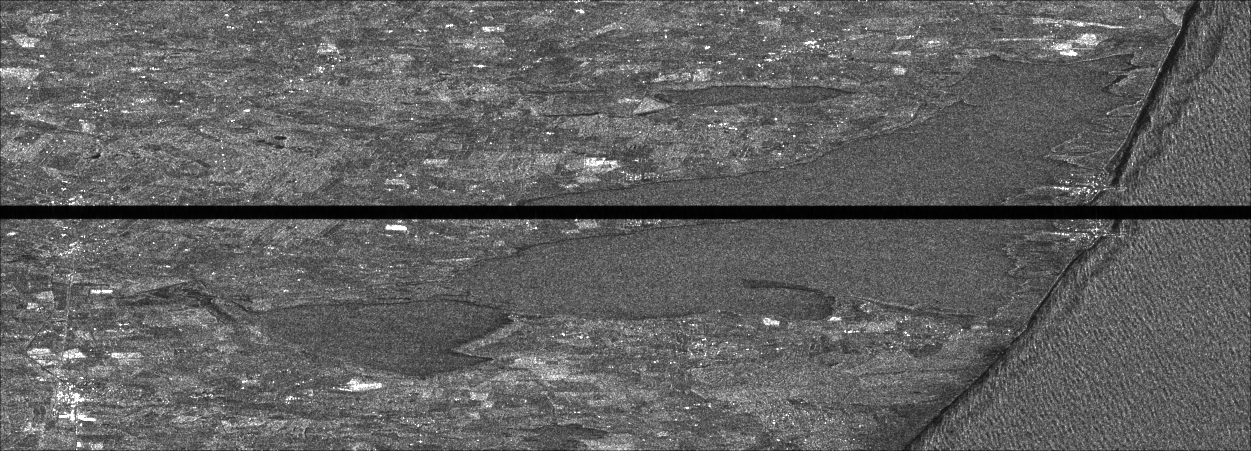

In [43]:
show_img(slice_test)

In [44]:
slice_test.meta

Dict{String,Any} with 20 entries:
  "image_number"          => "006"
  "mode"                  => "IW"
  "mission_data_id"       => "33712"
  "burst_meta"            => Dict{String,Any}("first_line_mosaic"=>[1, 1343, 26…
  "samples_per_burst"     => 25330
  "geolocation"           => Dict{String,Any}("line"=>[1, 1, 1, 1, 1, 1, 1, 1, …
  "polarisation"          => "VV"
  "absolute_orbit_number" => "4715"
  "slant_range_time"      => 0.00602248
  "t_start"               => 50.7031
  "azimuth_frequency"     => 486.486
  "t_stop"                => 78.6587
  "pass"                  => "Descending"
  "mission_id"            => "S1B"
  "product_type"          => "SLC"
  "burst_count"           => 10
  "range_pixel_spacing"   => 2.32956
  "lines_per_burst"       => 1524
  "t_0"                   => 2017-03-15T05:39:00
  "swath"                 => 3

In [45]:
length(1:25330)

25330

In [46]:
function original_view(s1_ann)
    return [1:(s1_ann["lines_per_burst"]*s1_ann["burst_count"]),1:s1_ann["samples_per_burst"]]
end

original_view (generic function with 1 method)

In [47]:
original_view(slice_test.meta)

2-element Array{UnitRange{Int64},1}:
 1:15240
 1:25330